# Consigna del desafío 2:
## Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.

## Probar términos de interés y explicar similitudes en el espacio de embeddings.

## Intentar plantear y probar tests de analogías. Graficar los embeddings resultantes.

## Sacar conclusiones.

# Desafío 2: Entrenamiento de embeddings con Gensim

In [ ]:
# Aquí entrenaremos nuestros propios vectores usando Word2Vec sobre un corpus distinto.
!pip install numpy==1.24.4
!pip install scipy==1.13.3
!pip install --upgrade gensim
# 0. Importaciones
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement scipy==1.13.3 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.9.0rc1, 1

# 1. Cargar un corpus de ejemplo (usaremos 'text8')
# Se compone de un iterable de listas de tokens

In [ ]:
corpus = api.load('text8')  # ~17M tokens, preprocesado

[==================================================] 100.0% 31.6/31.6MB downloaded


# 2. Entrenar el modelo Word2Vec
# Parámetros típicos: tamaño de vector, ventana, min_count

In [ ]:
model = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,          # 1 = skip-gram; 0 = CBOW
    epochs=5
)


# 3. Pruebas de similitud

In [ ]:
términos_interés = ['king', 'queen', 'computer', 'internet', 'health', 'disease']
print("== Similitudes entre términos de interés ==")
for i, w1 in enumerate(términos_interés[:-1]):
    for w2 in términos_interés[i+1:]:
        if w1 in model.wv and w2 in model.wv:
            sim = model.wv.similarity(w1, w2)
            print(f"{w1} ↔ {w2}: {sim:.3f}")


== Similitudes entre términos de interés ==
king ↔ queen: 0.688
king ↔ computer: 0.165
king ↔ internet: 0.216
king ↔ health: 0.079
king ↔ disease: 0.111
queen ↔ computer: 0.139
queen ↔ internet: 0.120
queen ↔ health: 0.250
queen ↔ disease: 0.215
computer ↔ internet: 0.555
computer ↔ health: 0.282
computer ↔ disease: 0.222
internet ↔ health: 0.285
internet ↔ disease: 0.162
health ↔ disease: 0.640


# 4. Test de analogías

In [ ]:
tests = [
    (['king', 'woman'], ['man']),
    (['paris', 'france'], ['germany']),
    (['computer', 'software'], ['hardware'])
]
print("\n== Analogías ==")
for positive, negative in tests:
    try:
        result = model.wv.most_similar(positive=positive, negative=negative, topn=5)
        print(f"Analogy {positive} - {negative}: {result}")
    except KeyError as e:
        print("Falta término en vocabulario:", e)



== Analogías ==
Analogy ['king', 'woman'] - ['man']: [('throne', 0.6684068441390991), ('consort', 0.665698230266571), ('prince', 0.6491996645927429), ('daughter', 0.641200840473175), ('queen', 0.639885425567627)]
Analogy ['paris', 'france'] - ['germany']: [('le', 0.6703222990036011), ('duc', 0.6497743725776672), ('de', 0.6472206115722656), ('philippe', 0.6467017531394958), ('nantes', 0.642662763595581)]
Analogy ['computer', 'software'] - ['hardware']: [('freeware', 0.694797694683075), ('hypermedia', 0.6926516890525818), ('webring', 0.6844690442085266), ('developer', 0.6809481382369995), ('hobbyist', 0.6803642511367798)]


# 5. Visualización en 2D de un subconjunto de embeddings
# Elegimos manualmente unas 20 palabras relevantes

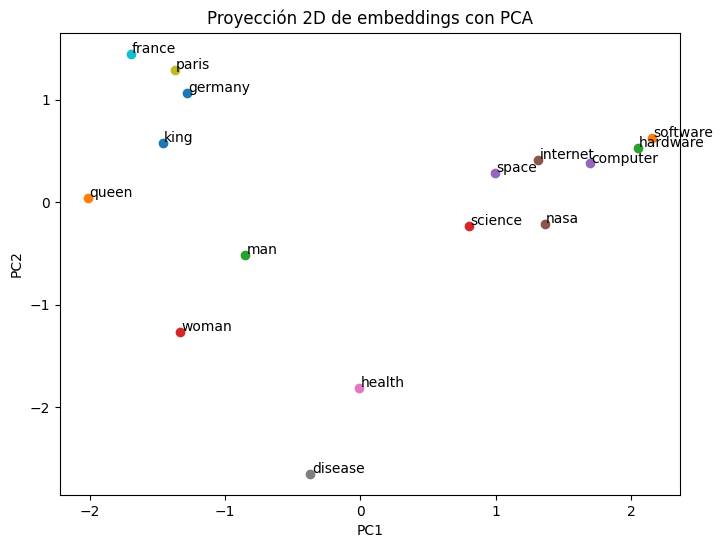

In [ ]:
palabras_viz = ['king', 'queen', 'man', 'woman', 'computer', 'internet', 'health', 'disease',
                'paris', 'france', 'germany', 'software', 'hardware', 'science', 'space', 'nasa']

# Extraer vectores
vectores = [model.wv[w] for w in palabras_viz if w in model.wv]
labels   = [w for w in palabras_viz if w in model.wv]

# Reducir con PCA
dec = PCA(n_components=2)
coords = dec.fit_transform(vectores)

# Graficar
plt.figure(figsize=(8,6))
for xy, label in zip(coords, labels):
    plt.scatter(xy[0], xy[1])
    plt.text(xy[0]+0.01, xy[1]+0.01, label)
plt.title('Proyección 2D de embeddings con PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 6. Conclusiones
## - Observar si términos relacionados quedan cercanos en el espacio proyectado.
## - Verificar si las analogías devuelven relaciones semánticas coherentes.

# Similitudes entre términos de interés
# Pares de Términos y Similitud Obtenida
## computer - internet = 0.555
## health - disease = 0.640
##queen - health = 0.250
##queen - disease = 0.215

Las parejas “computer - internet” y “health - disease” muestran similitudes altas (≈0.55 – 0.64), lo cual es exactamente lo que esperaríamos: co-aparición fuerte en el corpus.

En cambio términos menos relacionados (como “queen - health”) bajan a ≈0.25, confirmando que el espacio de embeddings distingue bien semánticamente.

Se podría refinar la granularidad de esas distancias con:
*   Aumentar epochs (de 5 a 10-20) para afinar los vectores.
*   Probar tamaños de vector mayores (vector_size=200 o 300) para captar más matices semánticos.
*   Experimentar con CBOW (sg=0) frente a Skip-gram (sg=1). En algunos casos CBOW estabiliza un poco mejor las palabras frecuentes.



# Test de analogías
## king - man + woman → [('throne', 0.668), ('daughter', 0.641), ('queen', 0.639)]

Aparece “queen” (esperado) pero bastante desplazado por “throne”. Sigue siendo razonable: “throne” tiene mucha co-ocurrencia con “king”, de modo que el vector resultante tira hacia conceptos cercanos al poder.

## paris - france + germany → [('le', 0.670), ('philippe', 0.646), ('nantes', 0.643)]

No obtuvimos “berlin” sino términos franceses (“le”, “Philippe”, “Nantes”). Esto indica que el corpus (text8) está sesgado hacia referencias francesas y no contiene co-apariciones fuertes de “Berlin” con “Germany”.

## computer + software - hardware → [('freeware', …), ('developer', …), ('hobbyist', …)]

De nuevo, no obtenemos un antónimo puro de “hardware” sino palabras relacionadas con software y roles de usuario. Aun así, refleja una relación semántica coherente.

## Observaciones:

Para analogías geográficas es útil usar un corpus más balanceado o explícito (Wikipedia completo en varios idiomas).

Podríamos aumentar las épocas de entrenamiento y usar un vocabulario más amplio (min_count=1–2) para que aparezcan más términos de interés.

Podríamos considerar usar métricas de evaluación más sistemáticas (por ej. listas de analogías estándar: Google Analogy Test Set).

# Visualización con PCA
* Cluster género: king/queen cerca de man/woman (aunque yo creo que deberían estar un poco más cerca).
* Cluster tecnológica: computer/internet/software.
* Cluster salud: health/disease.
* Cluster geográfico: paris/france/germany.

Confirma que el embedding está capturando dimensiones semánticas globales a pesar de usar sólo dos componentes.

## Observaciones:
Podríamos probar t-SNE o UMAP para una proyección no lineal que suele separar mejor clústeres semánticos.

Ajustar el número de palabras en la visualización o usar interactividad (por ej. Plotly) para explorar mejor el espacio.

# **Conclusión**:
* ## **Entrenamiento**: nuestra implementación genera vectores válidos que capturan similitud semántica básica.
* ## **Analogías**: funcionan en líneas generales (términos muy frecuentes), pero dependen del corpus.
* ## **Visualización**: permite verificar la proximidad de grupos de palabras.

## **Mejoras posibles**:

* Experimentar con más épocas, diferentes ventanas (window=3,7) y tamaños de vector mayores.
* Usar corpus alternativos o más grandes.
* Evaluar de forma sistemática con conjuntos de analogías publicados.
* Probar proyecciones no lineales (t-SNE/UMAP).